<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/Text_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will demonstrate Text classification using Recurrent Neural Networks (RNNs). Text classification is a fundamental natural language processing (NLP) task that involves assigning predefined categories or labels to textual data. RNNs are a class of deep learning models that excel at handling sequential data, making them well-suited for processing and understanding text data.

In [1]:
#Download BBC News dataset
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2023-07-28 11:25:45--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.1s    

2023-07-28 11:25:46 (47.6 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [2]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [3]:
# load dataset
df = pd.read_csv("bbc_text_cls.csv")
#preview
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
df['targets'] = df['labels'].astype("category").cat.codes

In [5]:
# number of classes
K = df.targets.max() + 1
K

5

In [6]:
#split into training and test sets
df_train, df_test = train_test_split(df, test_size = .2, random_state = 42)

In [7]:
#convert sequence to text
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequence_train = tokenizer.texts_to_sequences(df_train['text'])
sequence_test = tokenizer.texts_to_sequences(df_test['text'])

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found {} unique tokens.'.format(V))

Found 29278 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequence_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

data_test = pad_sequences(sequence_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data train tensor: (1780, 2827)
Shape of data test tensor: (445, 2827)


In [10]:
#Create a  model
# We get to choose embedding dimensionality
D = 20
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(32,return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i,x)

In [11]:
#compile
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics= ['accuracy']
)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2827)]            0         
                                                                 
 embedding (Embedding)       (None, 2827, 20)          585580    
                                                                 
 lstm (LSTM)                 (None, 2827, 32)          6784      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 592,529
Trainable params: 592,529
Non-trainable params: 0
_______________________________________________________

In [13]:
print('Training model...')
r = model.fit(
  data_train,
  df_train['targets'],
  epochs=50,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/50
56/56 [==============================] - 25s 319ms/step - loss: 1.5984 - accuracy: 0.2444 - val_loss: 1.5753 - val_accuracy: 0.3146
Epoch 2/50
56/56 [==============================] - 13s 226ms/step - loss: 1.5439 - accuracy: 0.4483 - val_loss: 1.4638 - val_accuracy: 0.7483
Epoch 3/50
56/56 [==============================] - 12s 219ms/step - loss: 1.1776 - accuracy: 0.6455 - val_loss: 0.8812 - val_accuracy: 0.7056
Epoch 4/50
56/56 [==============================] - 7s 129ms/step - loss: 0.6814 - accuracy: 0.7545 - val_loss: 0.6849 - val_accuracy: 0.7708
Epoch 5/50
56/56 [==============================] - 9s 158ms/step - loss: 0.5253 - accuracy: 0.8820 - val_loss: 0.6440 - val_accuracy: 0.8404
Epoch 6/50
56/56 [==============================] - 8s 132ms/step - loss: 0.5251 - accuracy: 0.8787 - val_loss: 0.6399 - val_accuracy: 0.7865
Epoch 7/50
56/56 [==============================] - 7s 121ms/step - loss: 0.4926 - accuracy: 0.8854 - val_loss: 0.4427 - val_ac

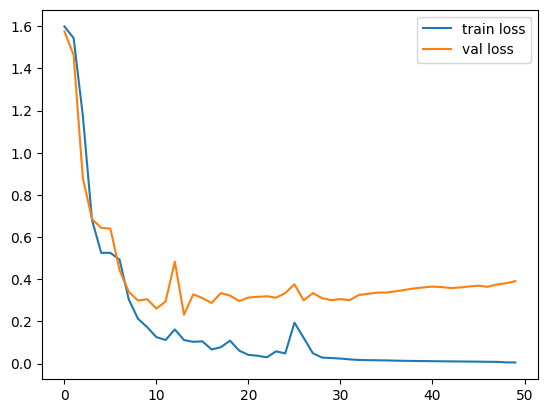

In [14]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

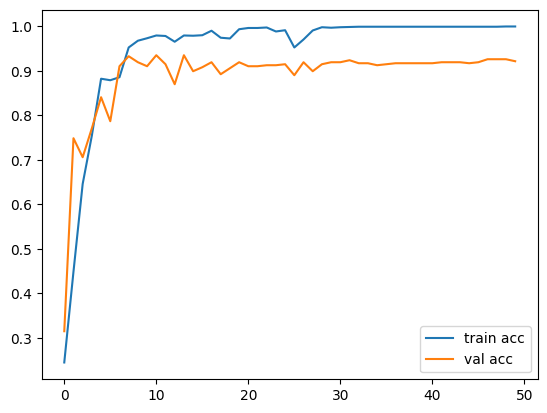

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();